In [3]:
# Confirm installation
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
import os
import pandas as pd

# Define dataset paths
images_dir = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images'  # Update this path if necessary
labels_csv = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\train.csv'  # Update this path if necessary

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_csv)

# Display the column names in the CSV file to check the correct label column
print("Column names in the CSV file:")
print(labels_df.columns)

# Display the first few rows to understand the structure
print("\nFirst few rows of the CSV file:")
print(labels_df.head())

# Check image directory structure
categories = os.listdir(images_dir)
print("\nCategories in the image directory:", categories)

# List a few image file names from one category to ensure the path structure
sample_images = os.listdir(os.path.join(images_dir, categories[0]))
print(f"\nSample images from category {categories[0]}: {sample_images[:5]}")



Column names in the CSV file:
Index(['id_code', 'diagnosis'], dtype='object')

First few rows of the CSV file:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Categories in the image directory: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

Sample images from category Mild: ['0024cdab0c1e.png', '00cb6555d108.png', '0124dffecf29.png', '01b3aed3ed4c.png', '0369f3efe69b.png']


In [5]:
# Map the diagnosis labels to their corresponding images
labels_df['image_path'] = labels_df['id_code'].apply(lambda x: os.path.join(images_dir, f"{x}.png"))

# Display the first few mappings of image paths to diagnosis
print("\nMapping of image paths to diagnosis:")
print(labels_df[['image_path', 'diagnosis']].head())

# Check the distribution of the diagnosis classes
print("\nDistribution of diagnosis labels:")
print(labels_df['diagnosis'].value_counts())



Mapping of image paths to diagnosis:
                                          image_path  diagnosis
0  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          2
1  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          4
2  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          1
3  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          0
4  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          0

Distribution of diagnosis labels:
diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
train_df, test_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['diagnosis'], random_state=42)

# Display the sizes of the training and testing sets
print(f"Training set size: {train_df.shape[0]} samples")
print(f"Testing set size: {test_df.shape[0]} samples")

# Display the first few entries of the training set to confirm
print("\nFirst few rows of the training set:")
print(train_df[['image_path', 'diagnosis']].head())


Training set size: 2929 samples
Testing set size: 733 samples

First few rows of the training set:
                                             image_path  diagnosis
2579  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          0
309   C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          2
2826  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          3
2989  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          0
3344  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...          2


In [7]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
images_dir = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images'  # Update this path if necessary
labels_csv = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\train.csv'

# Load the CSV file
labels_df = pd.read_csv(labels_csv)

# Map the diagnosis column to strings (for flow_from_dataframe compatibility)
labels_df['diagnosis'] = labels_df['diagnosis'].astype(str)

# Define the correct image paths based on the folder structure
def construct_image_path(row):
    class_label = {
        '0': 'No_DR',
        '1': 'Mild',
        '2': 'Moderate',
        '3': 'Severe',
        '4': 'Proliferate_DR'
    }[row['diagnosis']]
    return os.path.join(images_dir, class_label, f"{row['id_code']}.png")

# Apply the function to create the full paths
labels_df['image_path'] = labels_df.apply(construct_image_path, axis=1)

# Check the first few rows to ensure paths are correct
print("\nFirst few updated image paths:")
print(labels_df[['image_path', 'diagnosis']].head())

# Split the data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['diagnosis'], random_state=42)

# Define the image size and batch size
IMG_SIZE = (224, 224)  # ResNet input size
BATCH_SIZE = 32

# Create ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Rescale pixel values to [0, 1]
    rotation_range=20,             # Randomly rotate images
    width_shift_range=0.2,         # Randomly shift images horizontally
    height_shift_range=0.2,        # Randomly shift images vertically
    shear_range=0.2,               # Shear angle in counter-clockwise direction
    zoom_range=0.2,                # Randomly zoom in on images
    horizontal_flip=True,          # Randomly flip images horizontally
    fill_mode='nearest'            # Fill in missing pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

# Create training and testing generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Display some information about the generators
print(f"\nTraining generator has {train_generator.n} images in {train_generator.batch_size}-image batches.")
print(f"Testing generator has {test_generator.n} images in {test_generator.batch_size}-image batches.")



First few updated image paths:
                                          image_path diagnosis
0  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...         2
1  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...         4
2  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...         1
3  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...         0
4  C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Ret...         0
Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.

Training generator has 2929 images in 32-image batches.
Testing generator has 733 images in 32-image batches.


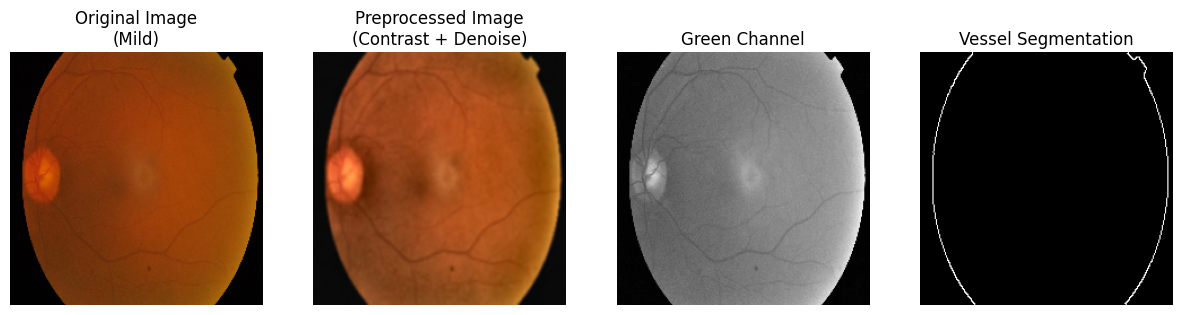

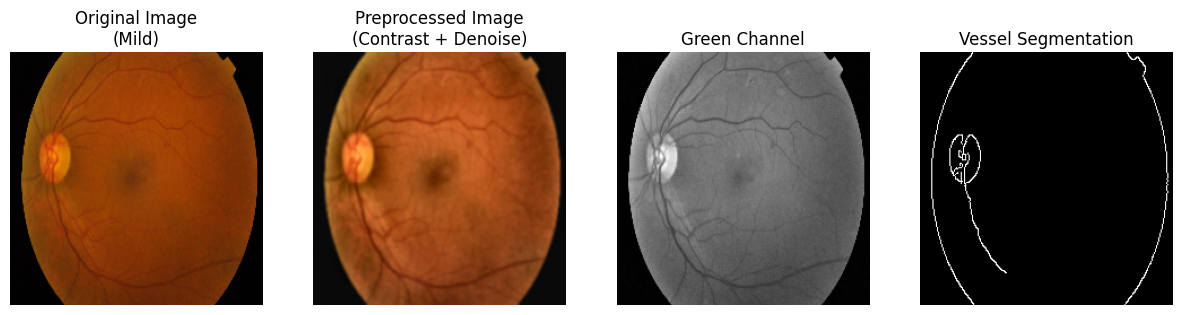

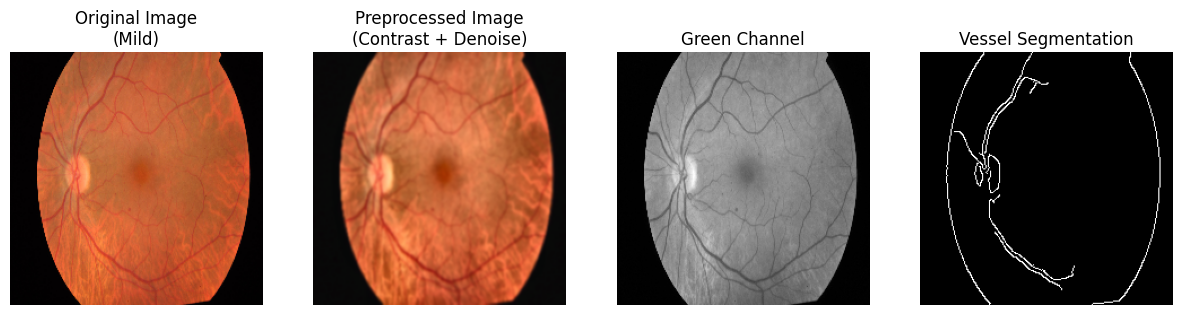

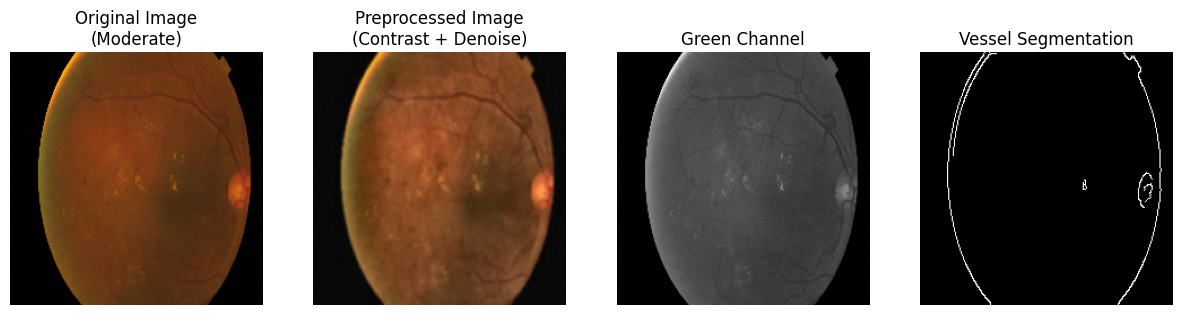

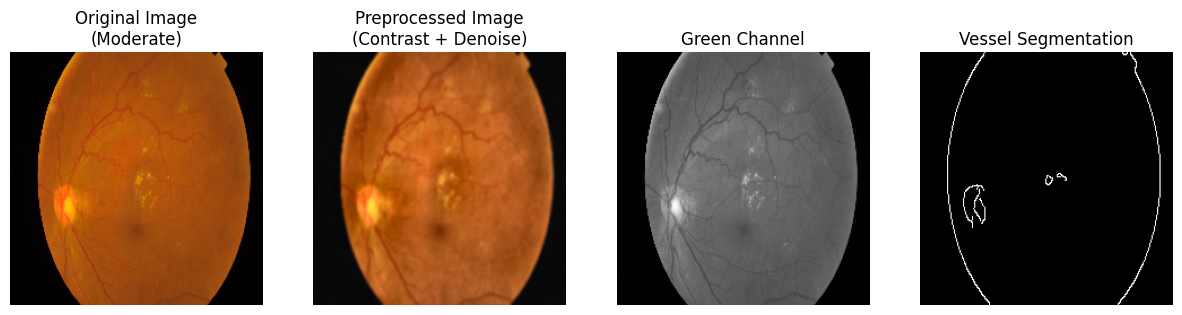

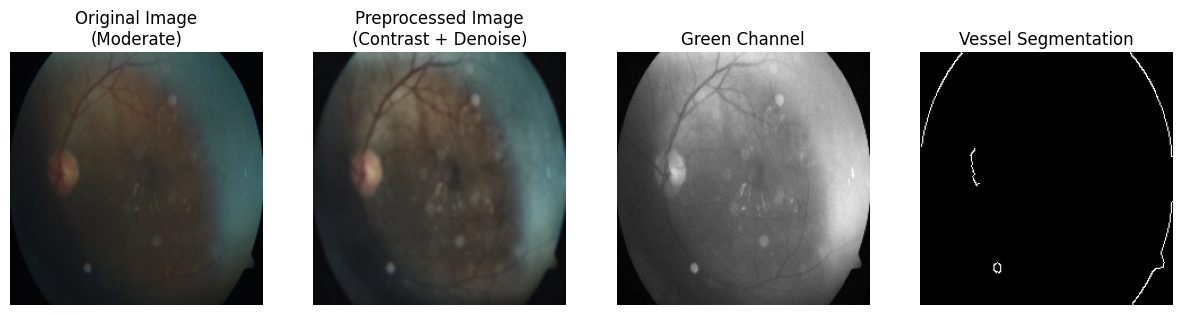

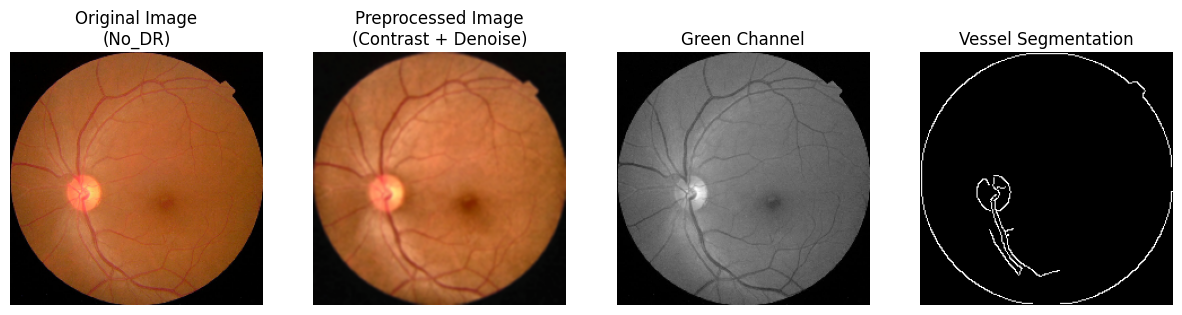

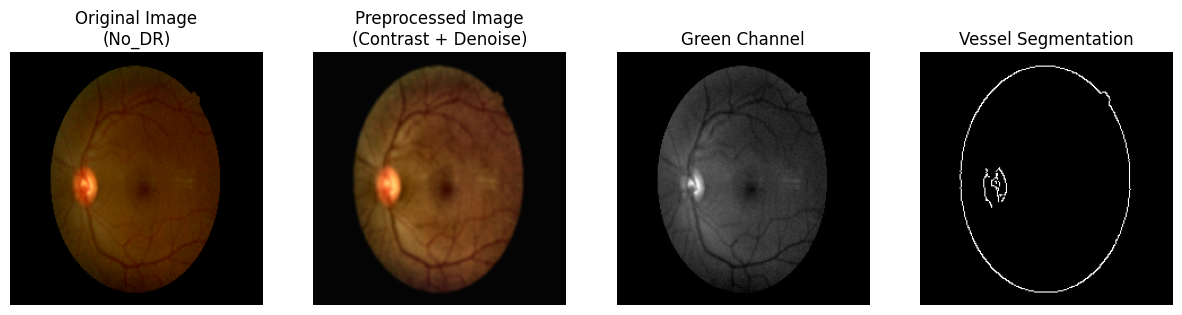

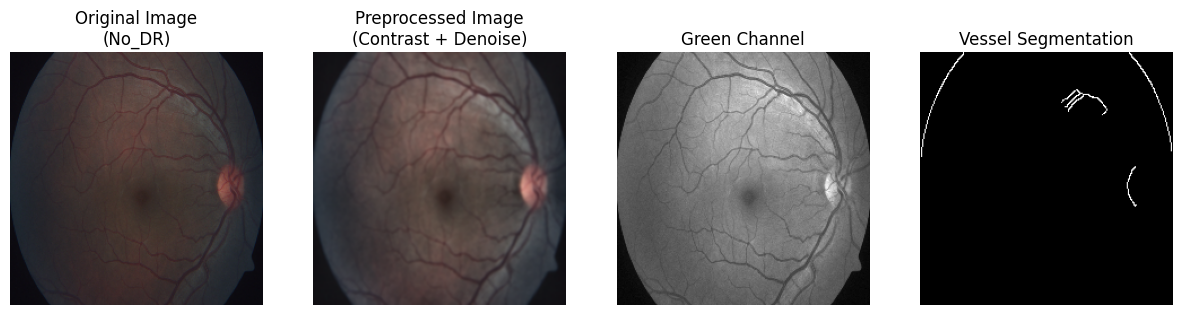

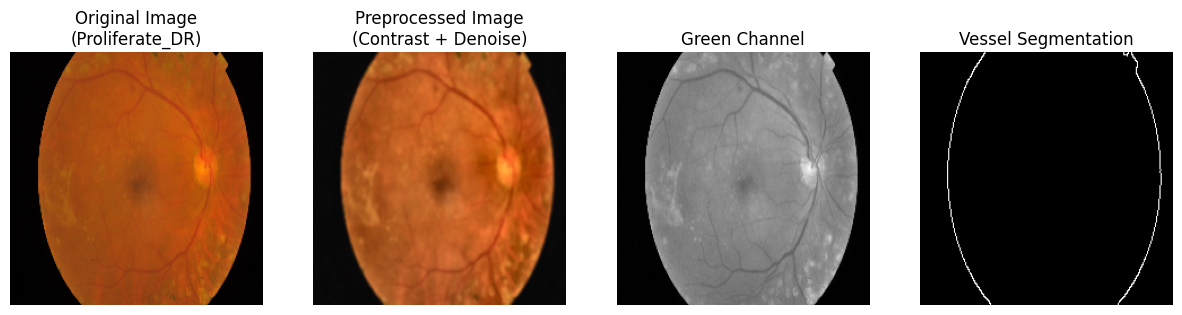

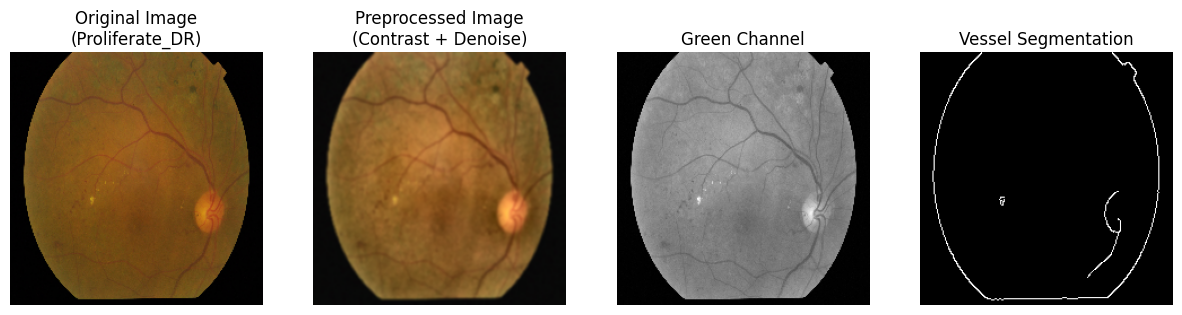

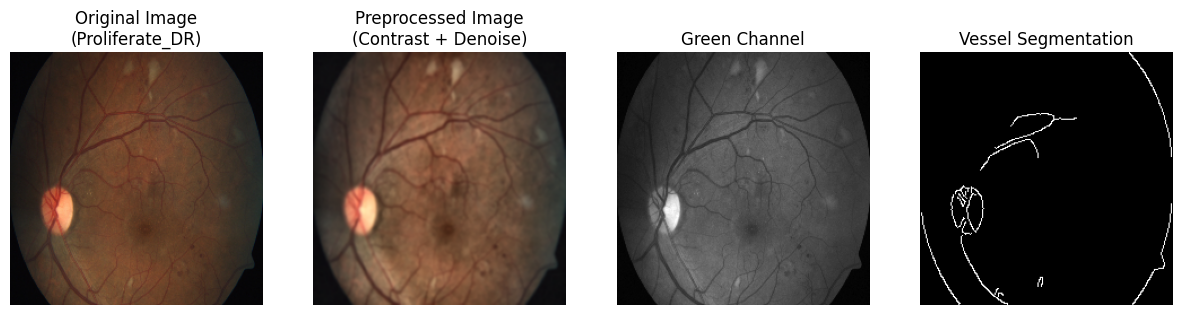

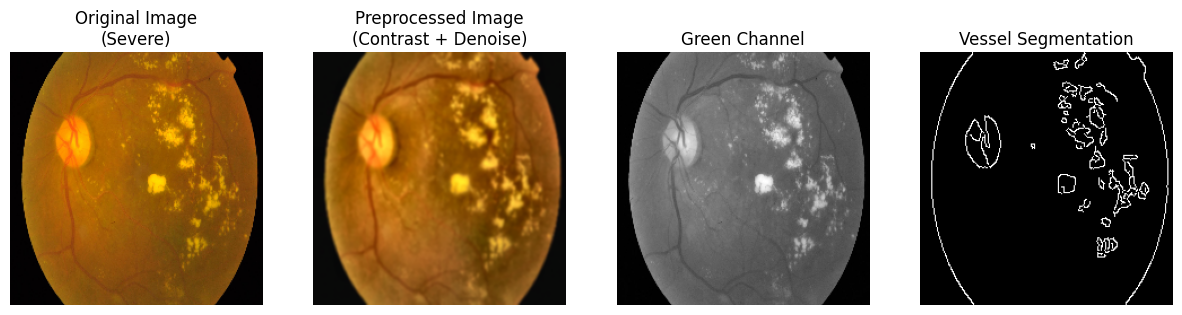

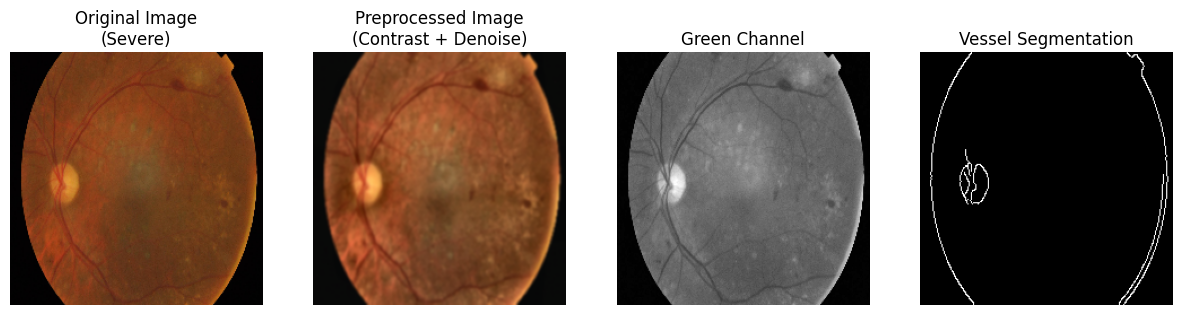

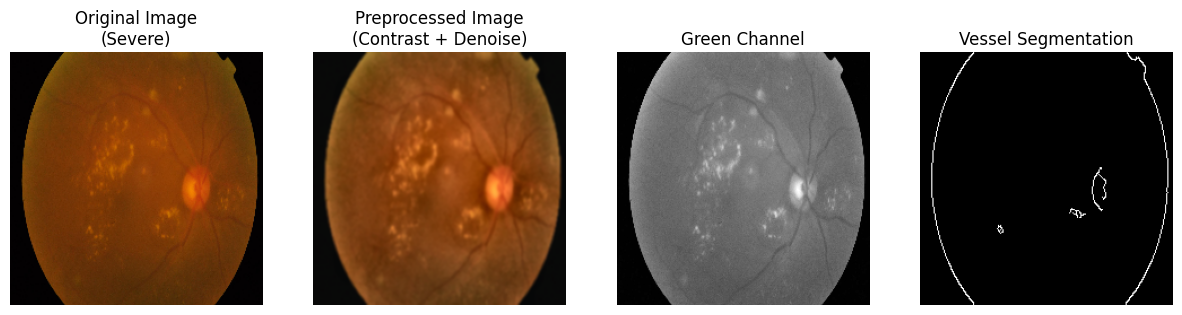

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define base image directory and subfolder names
base_image_dir = r'C:/Users/spars/Desktop/SEM 5/AIOT/Diabetic_Retinopathy_Detection_Project/Retinopathy_Dataset/colored_images'
subfolders = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Function to adjust contrast and brightness using CLAHE
def adjust_contrast_brightness(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    merged_lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)
    return enhanced_image

# Function to denoise the image
def denoise_image(image):
    denoised_image = cv2.GaussianBlur(image, (5, 5), 0)
    return denoised_image

# Function for green channel extraction
def extract_green_channel(image):
    return image[:, :, 1]

# Function for vessel segmentation using edge detection
def vessel_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)
    return edges

# Full preprocessing function
def preprocess_image(image):
    # Step 1: Apply contrast enhancement (CLAHE) and denoising
    enhanced_image = adjust_contrast_brightness(image)
    final_image = denoise_image(enhanced_image)
    
    # Step 2: Green channel extraction (optional)
    green_channel = extract_green_channel(image)
    
    # Step 3: Vessel segmentation (optional)
    vessels = vessel_segmentation(image)
    
    return final_image, green_channel, vessels

# Plot the first few images for each subfolder (class)
for subfolder in subfolders:
    # Get the full path of the subfolder
    folder_path = os.path.join(base_image_dir, subfolder)
    
    # Get the list of image files in the subfolder
    image_files = os.listdir(folder_path)[:3]  # Print only the first 3 images
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        
        # Read the image and convert to RGB
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Preprocess the image
        final_image, green_channel, vessels = preprocess_image(image_rgb)
        
        # Plot the original and preprocessed images
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 4, 1)
        plt.imshow(image_rgb)
        plt.title(f'Original Image\n({subfolder})')
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(final_image)
        plt.title('Preprocessed Image\n(Contrast + Denoise)')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(green_channel, cmap='gray')
        plt.title('Green Channel')
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(vessels, cmap='gray')
        plt.title('Vessel Segmentation')
        plt.axis('off')
        
        plt.show()


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model without the top layer and using pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional)
base_model.trainable = True  # Set this to True if you want to fine-tune the base model

# Define the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pooling layer to reduce the feature map size
    Dense(512, activation='relu'),  # Dense layer with 512 units
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(5, activation='softmax')  # Output layer for 5 classes (No_DR, Mild, Moderate, Severe, Proliferate_DR)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 24,586,245 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [35]:
# Train the model using the training generator and validate with the test generator
history = model.fit(
    train_generator,
    epochs=5,  # You can increase the number of epochs based on your dataset size
    validation_data=test_generator
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 693s 8s/step - accuracy: 0.7623 - loss: 0.6471 - val_accuracy: 0.5962 - val_loss: 1.1156
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 680s 7s/step - accuracy: 0.8220 - loss: 0.4951 - val_accuracy: 0.6821 - val_loss: 0.8710
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 676s 7s/step - accuracy: 0.8277 - loss: 0.4752 - val_accuracy: 0.7503 - val_loss: 0.7134
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 681s 7s/step - accuracy: 0.8531 - loss: 0.3918 - val_accuracy: 0.7790 - val_loss: 0.7053
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 635s 7s/step - accuracy: 0.8689 - loss: 0.3544 - val_accuracy: 0.7885 - val_loss: 0.5878


In [39]:
model.save("Diabetic_retinopathy_cnn.keras")

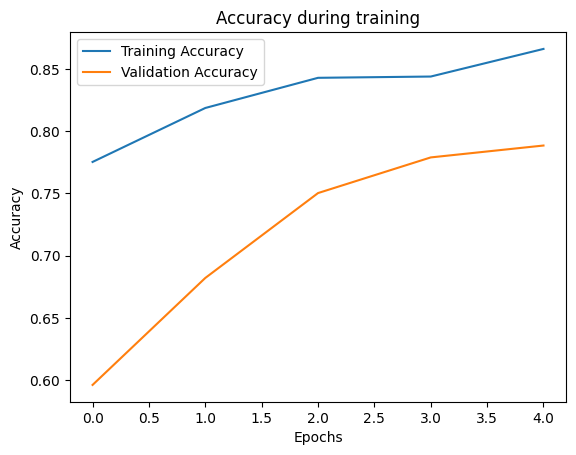

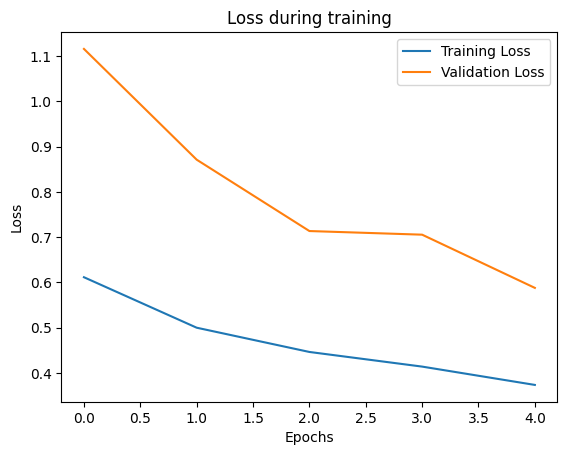

In [40]:
import matplotlib.pyplot as plt

# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


GREEN CHANNEL


In [16]:
# Define a custom preprocessing function for extracting the green channel and expanding it to 3 channels
def green_channel_preprocessing(image):
    # If the image is single-channel (grayscale), convert it to RGB
    if len(image.shape) == 2:  # Grayscale image will have only two dimensions
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Normalize the image
    image = image / 255.0
    
    # Extract the green channel
    green_channel = image[:, :, 1]  # Extract the second channel (green)
    
    # Expand the green channel to three channels (to match the expected input shape of the model)
    green_channel_3d = np.stack([green_channel]*3, axis=-1)
    
    # Return the 3-channel green channel image
    return green_channel_3d

# Create a custom ImageDataGenerator for green channel preprocessing
train_datagen_green = ImageDataGenerator(
    preprocessing_function=green_channel_preprocessing  # Apply green channel preprocessing
)

test_datagen_green = ImageDataGenerator(
    preprocessing_function=green_channel_preprocessing
)

# Create data generators
train_generator_green = train_datagen_green.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),  # Reshape to match the model input size
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'  # Force loading images as RGB
)

test_generator_green = test_datagen_green.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',  # Force loading images as RGB
    shuffle=False
)
'''
# Train the model with the green channel (expanded to 3 channels)
history_green = model.fit(
    train_generator_green,
    epochs=5,
    validation_data=test_generator_green
)
'''

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


'\n# Train the model with the green channel (expanded to 3 channels)\nhistory_green = model.fit(\n    train_generator_green,\n    epochs=5,\n    validation_data=test_generator_green\n)\n'

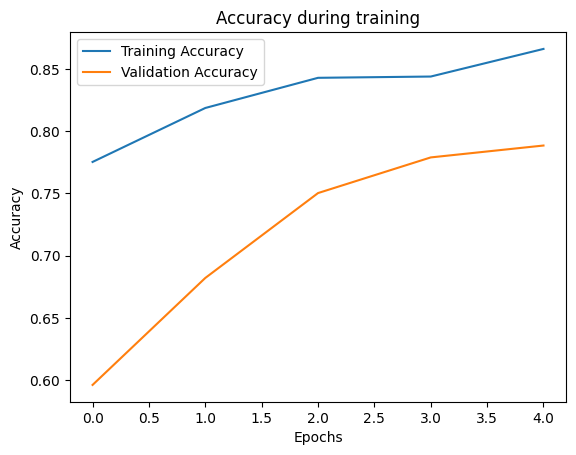

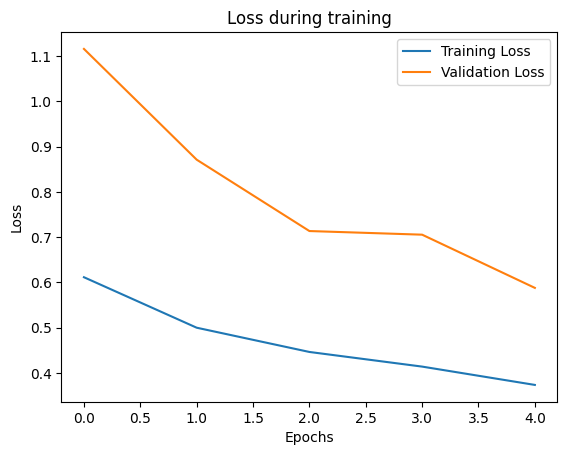

In [44]:
import matplotlib.pyplot as plt

# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [42]:
# Save the model after training with green channel preprocessing
model.save('diabetic_retinopathy_green_channel_model.keras')


VESSEL SEGMENTATION

In [11]:
import cv2
import numpy as np

# Define a custom preprocessing function for vessel segmentation and expanding it to 3 channels
def vessel_segmentation_preprocessing(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Ensure the image is in uint8 format before applying Canny
    blurred_image_uint8 = np.uint8(blurred_image)
    
    # Perform edge detection for vessel segmentation
    vessels = cv2.Canny(blurred_image_uint8, 30, 100)
    
    # Normalize to [0, 1] (optional, based on your preference)
    vessels = vessels / 255.0
    
    # Stack the single-channel vessel segmentation into 3 channels
    vessels_3d = np.stack([vessels]*3, axis=-1)
    
    # Return the 3-channel vessel segmentation image
    return vessels_3d

# Create a custom ImageDataGenerator for vessel segmentation preprocessing
train_datagen_vessel = ImageDataGenerator(
    preprocessing_function=vessel_segmentation_preprocessing  # Apply vessel segmentation preprocessing
)

test_datagen_vessel = ImageDataGenerator(
    preprocessing_function=vessel_segmentation_preprocessing
)

# Create data generators
train_generator_vessel = train_datagen_vessel.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'  # Force loading images as RGB
)

test_generator_vessel = test_datagen_vessel.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',  # Force loading images as RGB
    shuffle=False
)

# Train the model with vessel segmentation (expanded to 3 channels)
history_vessel = model.fit(
    train_generator_vessel,
    epochs=5,
    validation_data=test_generator_vessel
)


Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Epoch 1/5


C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 618s 7s/step - accuracy: 0.8311 - loss: 0.4946 - val_accuracy: 0.2729 - val_loss: 1.8390
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 619s 7s/step - accuracy: 0.8657 - loss: 0.3619 - val_accuracy: 0.2729 - val_loss: 2.1313
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 620s 7s/step - accuracy: 0.8933 - loss: 0.2850 - val_accuracy: 0.2729 - val_loss: 2.2923
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 646s 7s/step - accuracy: 0.9358 - loss: 0.1972 - val_accuracy: 0.2715 - val_loss: 2.5432
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 647s 7s/step - accuracy: 0.9488 - loss: 0.1578 - val_accuracy: 0.1392 - val_loss: 2.7958


In [12]:
model.save("diabetic_retinopathy_vessel.keras")

Green + vessel

In [13]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a custom preprocessing function for both green channel extraction and vessel segmentation
def combined_preprocessing(image):
    # Extract the green channel
    green_channel = image[:, :, 1]
    
    # Apply Gaussian blur to the green channel
    blurred_green = cv2.GaussianBlur(green_channel, (5, 5), 0)
    
    # Ensure the blurred green channel is in uint8 format before applying Canny
    blurred_green_uint8 = np.uint8(blurred_green)
    
    # Perform edge detection for vessel segmentation on the green channel
    vessels = cv2.Canny(blurred_green_uint8, 30, 100)
    
    # Normalize the vessel segmentation to [0, 1]
    vessels = vessels / 255.0
    
    # Stack the single-channel vessel segmentation into 3 channels to match the model's expected input shape
    vessels_3d = np.stack([vessels] * 3, axis=-1)
    
    return vessels_3d

# Create ImageDataGenerators with combined preprocessing
train_datagen_combined = ImageDataGenerator(preprocessing_function=combined_preprocessing)
test_datagen_combined = ImageDataGenerator(preprocessing_function=combined_preprocessing)

# Create data generators
train_generator_combined = train_datagen_combined.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),  # Reshape to match the model input size
    batch_size=32,  # Adjust batch size if needed
    class_mode='categorical',
    color_mode='rgb'  # Treat images as RGB (3 channels)
)

test_generator_combined = test_datagen_combined.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',  # Treat images as RGB (3 channels)
    shuffle=False
)

# Train the model with combined preprocessing
history_combined = model.fit(
    train_generator_combined,
    epochs=5,
    validation_data=test_generator_combined
)

# Save the model
model.save('combined_green_vessel_model.keras')


Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Epoch 1/5


C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 631s 7s/step - accuracy: 0.7741 - loss: 0.6658 - val_accuracy: 0.1446 - val_loss: 2.1054
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 635s 7s/step - accuracy: 0.9327 - loss: 0.2187 - val_accuracy: 0.1173 - val_loss: 2.4587
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 642s 7s/step - accuracy: 0.9458 - loss: 0.1599 - val_accuracy: 0.3452 - val_loss: 1.7189
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 647s 7s/step - accuracy: 0.9689 - loss: 0.1106 - val_accuracy: 0.5184 - val_loss: 1.4690
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 642s 7s/step - accuracy: 0.9801 - loss: 0.0649 - val_accuracy: 0.5880 - val_loss: 1.5098


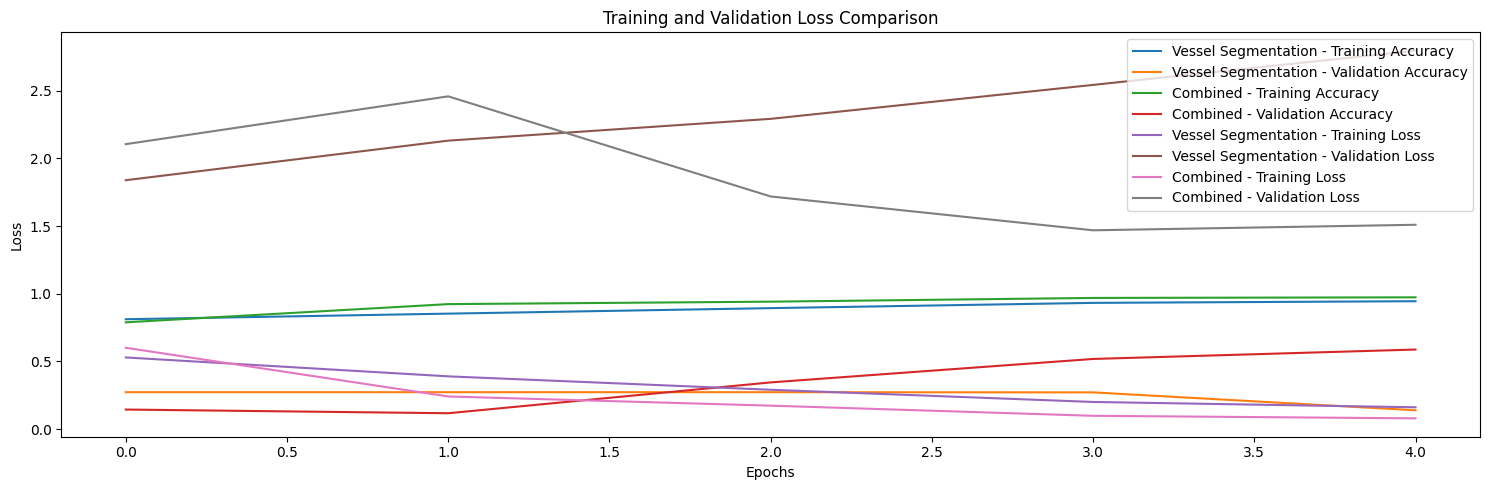

In [21]:
import matplotlib.pyplot as plt

# Assuming that you have trained your models and saved their training histories as `history_green`, `history_vessel`, and `history_combined`

# Plot accuracy for each model
plt.figure(figsize=(15, 5))



# Vessel Segmentation Model
plt.plot(history_vessel.history['accuracy'], label='Vessel Segmentation - Training Accuracy')
plt.plot(history_vessel.history['val_accuracy'], label='Vessel Segmentation - Validation Accuracy')

# Combined Preprocessing Model
plt.plot(history_combined.history['accuracy'], label='Combined - Training Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Combined - Validation Accuracy')

# Titles and labels
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.plot(history_vessel.history['loss'], label='Vessel Segmentation - Training Loss')
plt.plot(history_vessel.history['val_loss'], label='Vessel Segmentation - Validation Loss')

plt.plot(history_combined.history['loss'], label='Combined - Training Loss')
plt.plot(history_combined.history['val_loss'], label='Combined - Validation Loss')

# Titles and labels
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
Ensemble Accuracy: 0.7667121418826739
CNN Model Accuracy: 0.7871759890859482
Green Channel Model Accuracy: 0.7216916780354706
Vessel Segmentation Model Accuracy: 0.13915416098226466
Combined Model Accuracy: 0.5879945429740792


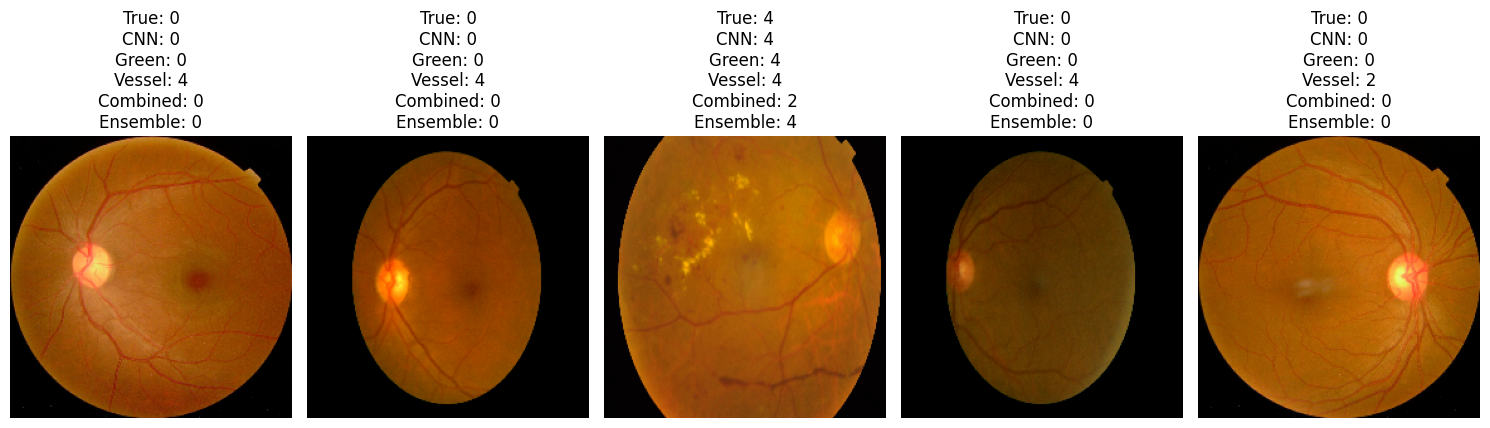

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

# Load the saved models
cnn_model = load_model('Diabetic_retinopathy_cnn.keras')
green_channel_model = load_model('diabetic_retinopathy_green_channel_model.keras')
vessel_model = load_model('diabetic_retinopathy_vessel.keras')
combined_model = load_model('combined_green_vessel_model.keras')

# Predict on test data using each model
cnn_preds = cnn_model.predict(test_generator)
green_preds = green_channel_model.predict(test_generator_green)
vessel_preds = vessel_model.predict(test_generator_vessel)
combined_preds = combined_model.predict(test_generator_combined)

# Average the predictions from all four models
ensemble_preds = (cnn_preds + green_preds + vessel_preds + combined_preds) / 4

# Convert the ensemble predictions to class labels
ensemble_labels = np.argmax(ensemble_preds, axis=1)

# Get the true labels from the test generator
true_labels = test_generator.classes

# Get the image file paths from the test generator
image_paths = test_generator.filepaths

# Calculate the ensemble accuracy
ensemble_accuracy = np.sum(ensemble_labels == true_labels) / len(true_labels)
print(f"Ensemble Accuracy: {ensemble_accuracy}")

# Optionally, you can calculate accuracy for each individual model for comparison:
cnn_accuracy = np.sum(np.argmax(cnn_preds, axis=1) == true_labels) / len(true_labels)
green_accuracy = np.sum(np.argmax(green_preds, axis=1) == true_labels) / len(true_labels)
vessel_accuracy = np.sum(np.argmax(vessel_preds, axis=1) == true_labels) / len(true_labels)
combined_accuracy = np.sum(np.argmax(combined_preds, axis=1) == true_labels) / len(true_labels)

print(f"CNN Model Accuracy: {cnn_accuracy}")
print(f"Green Channel Model Accuracy: {green_accuracy}")
print(f"Vessel Segmentation Model Accuracy: {vessel_accuracy}")
print(f"Combined Model Accuracy: {combined_accuracy}")

# Plot the first 5 images with predictions
plt.figure(figsize=(15, 10))
for i in range(5):
    img_path = image_paths[i]
    img = plt.imread(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_labels[i]}\n"
              f"CNN: {np.argmax(cnn_preds[i])}\n"
              f"Green: {np.argmax(green_preds[i])}\n"
              f"Vessel: {np.argmax(vessel_preds[i])}\n"
              f"Combined: {np.argmax(combined_preds[i])}\n"
              f"Ensemble: {ensemble_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


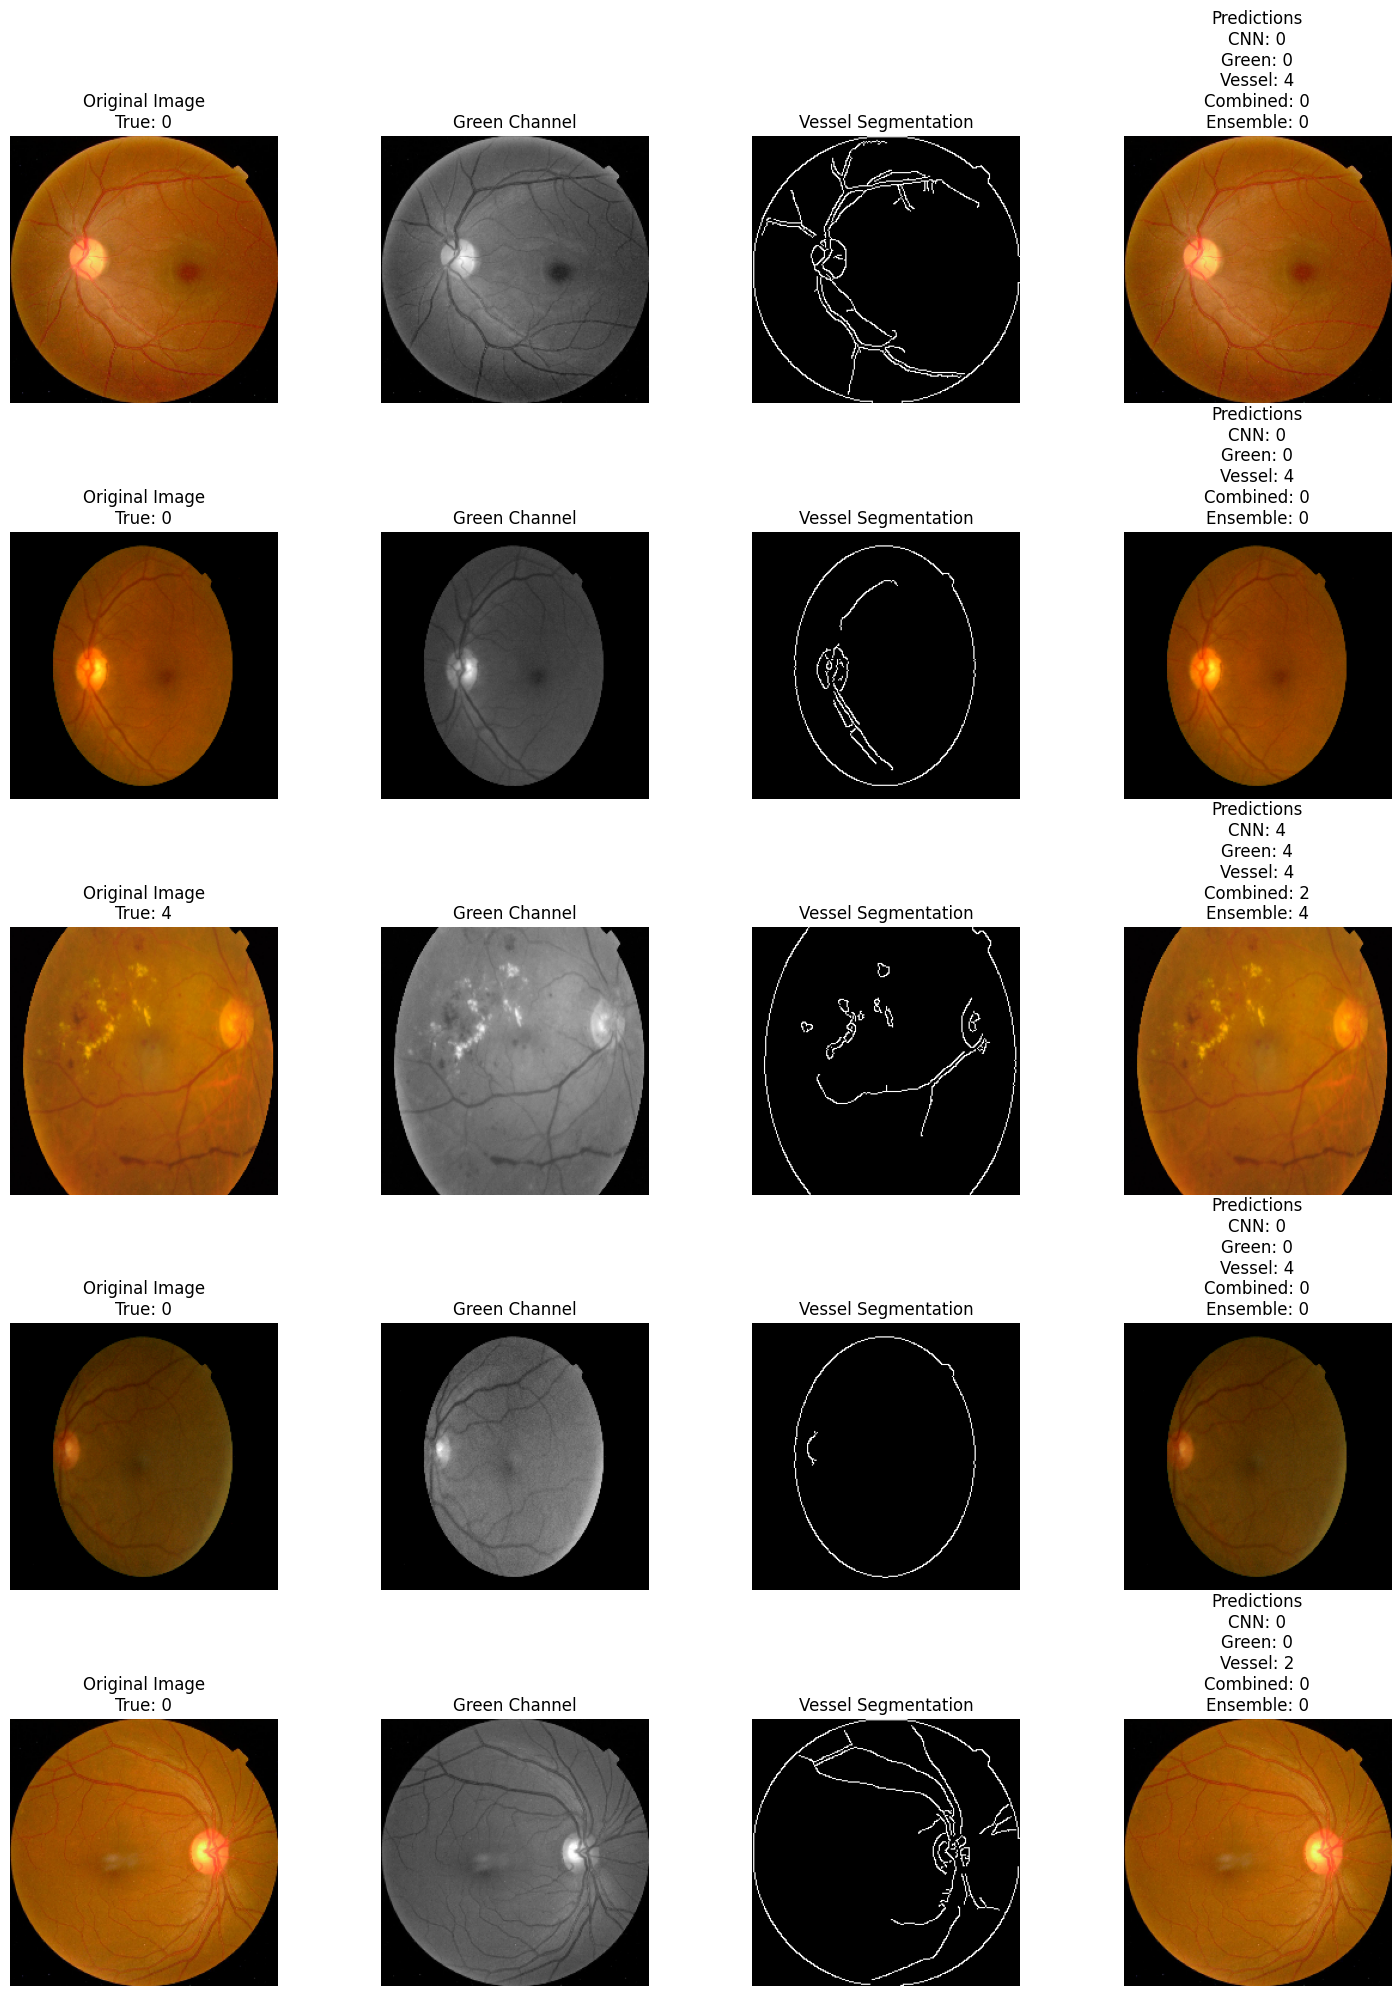

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Function to extract green channel
def extract_green_channel(image):
    # Extract the green channel
    green_channel = image[:, :, 1]
    return green_channel

# Function for vessel segmentation
def vessel_segmentation(image):
    # Extract the green channel
    green_channel = image[:, :, 1]
    # Apply Gaussian blur
    blurred_green = cv2.GaussianBlur(green_channel, (5, 5), 0)
    # Apply Canny edge detection
    vessels = cv2.Canny(np.uint8(blurred_green), 30, 100)
    return vessels

# Load the saved models
cnn_model = load_model('Diabetic_retinopathy_cnn.keras')
green_channel_model = load_model('diabetic_retinopathy_green_channel_model.keras')
vessel_model = load_model('diabetic_retinopathy_vessel.keras')
combined_model = load_model('combined_green_vessel_model.keras')

# Predict on test data using each model
cnn_preds = cnn_model.predict(test_generator)
green_preds = green_channel_model.predict(test_generator_green)
vessel_preds = vessel_model.predict(test_generator_vessel)
combined_preds = combined_model.predict(test_generator_combined)

# Average the predictions from all four models
ensemble_preds = (cnn_preds + green_preds + vessel_preds + combined_preds) / 4
ensemble_labels = np.argmax(ensemble_preds, axis=1)
true_labels = test_generator.classes
image_paths = test_generator.filepaths

# Plot the first 5 images with preprocessing and predictions
plt.figure(figsize=(15, 20))

for i in range(5):
    img_path = image_paths[i]
    img = cv2.imread(img_path)  # Load the original image using OpenCV
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # Green channel extraction
    green_channel = extract_green_channel(img_rgb)
    
    # Vessel segmentation
    vessel_image = vessel_segmentation(img_rgb)

    # Display original image
    plt.subplot(5, 4, i * 4 + 1)
    plt.imshow(img_rgb)
    plt.title(f"Original Image\nTrue: {true_labels[i]}")
    plt.axis('off')

    # Display green channel image
    plt.subplot(5, 4, i * 4 + 2)
    plt.imshow(green_channel, cmap='gray')  # Display green channel as grayscale
    plt.title(f"Green Channel")
    plt.axis('off')

    # Display vessel segmentation image
    plt.subplot(5, 4, i * 4 + 3)
    plt.imshow(vessel_image, cmap='gray')  # Display vessel segmentation (black and white)
    plt.title(f"Vessel Segmentation")
    plt.axis('off')

    # Display predictions
    plt.subplot(5, 4, i * 4 + 4)
    plt.imshow(img_rgb)
    plt.title(f"Predictions\nCNN: {np.argmax(cnn_preds[i])}\n"
              f"Green: {np.argmax(green_preds[i])}\n"
              f"Vessel: {np.argmax(vessel_preds[i])}\n"
              f"Combined: {np.argmax(combined_preds[i])}\n"
              f"Ensemble: {ensemble_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


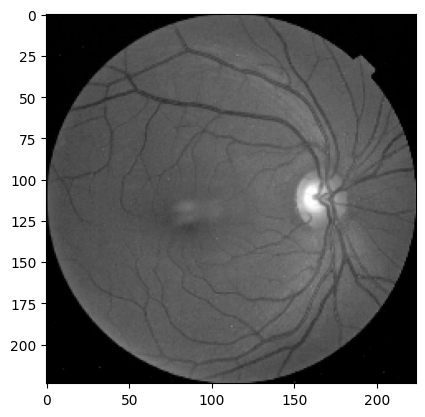

In [40]:
plt.imshow(green_channel, cmap='gray')


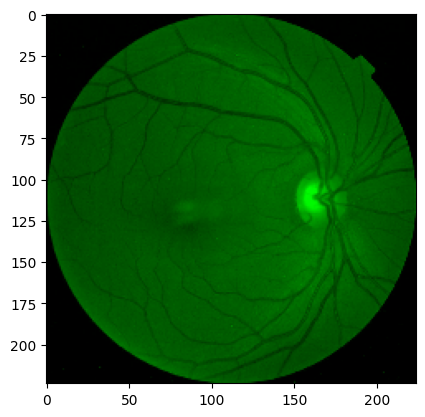

In [41]:
plt.imshow(np.stack([np.zeros_like(green_channel), green_channel, np.zeros_like(green_channel)], axis=-1))
